In [2]:
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

### Importing DataFrame functions and an extension of the "missing" functions from Pandas

In [3]:
%run utils/u.0.0-pandas_missing_extension.ipynb
%run utils/u.0.1-df_functions.ipynb
%run utils/u.0.3-statistical-functions.ipynb

#### Getting Processed Data

In [4]:
arg_di_df = pd.read_csv('../data/processed/WDICSV_PROCESSED.csv').clean_names(case_type="snake")

print(arg_di_df.shape)
arg_di_df.info()

(54, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  54 non-null     int64  
 1   it_mlt_main           54 non-null     float64
 2   ny_gdp_mktp_kd        54 non-null     float64
 3   ny_gdp_mktp_kd_zg     54 non-null     float64
 4   ny_gdp_pcap_kd        54 non-null     float64
 5   ny_gdp_pcap_kd_zg     54 non-null     float64
 6   sp_dyn_le00_in        53 non-null     float64
 7   it_cel_sets           50 non-null     float64
 8   sh_dth_imrt           53 non-null     float64
 9   sh_dth_mort           49 non-null     float64
 10  sp_pop_0014_to_zs     54 non-null     float64
 11  sp_pop_1564_to_zs     54 non-null     float64
 12  sp_pop_65_up_to_zs    54 non-null     float64
 13  sp_pop_totl           54 non-null     float64
 14  se_prm_ages           54 non-null     float64
 15  sm_pop_refg     

#### Getting indicators names and codes

In [5]:
indicators_names = [item + ", " + get_indicator_name(item, True) for item in arg_di_df.columns]
indicators_names

['year, year',
 'it_mlt_main, Fixed telephone subscriptions',
 'ny_gdp_mktp_kd, GDP (constant 2015 US$)',
 'ny_gdp_mktp_kd_zg, GDP growth (annual %)',
 'ny_gdp_pcap_kd, GDP per capita (constant 2015 US$)',
 'ny_gdp_pcap_kd_zg, GDP per capita growth (annual %)',
 'sp_dyn_le00_in, Life expectancy at birth, total (years)',
 'it_cel_sets, Mobile cellular subscriptions',
 'sh_dth_imrt, Number of infant deaths',
 'sh_dth_mort, Number of under-five deaths',
 'sp_pop_0014_to_zs, Population ages 0-14 (% of total population)',
 'sp_pop_1564_to_zs, Population ages 15-64 (% of total population)',
 'sp_pop_65_up_to_zs, Population ages 65 and above (% of total population)',
 'sp_pop_totl, Population, total',
 'se_prm_ages, Primary school starting age (years)',
 'sm_pop_refg, Refugee population by country or territory of asylum',
 'sm_pop_refg_or, Refugee population by country or territory of origin',
 'sp_rur_totl_zs, Rural population (% of total population)',
 'se_pre_enrr, School enrollment, prepr

#### Discarding variables

##### se_prm_ages, Primary school starting age (years)
I'll discard this variable because it always has the same value

In [6]:
if arg_di_df.get("se_prm_ages") is not None:
    print(arg_di_df["se_prm_ages"].value_counts())
    arg_di_df = arg_di_df.drop(columns=["se_prm_ages"])

se_prm_ages
6.0    54
Name: count, dtype: int64


##### se_sec_durs, Secondary education, duration (years)
I'll discard this variable because the duration of secondary education is different in different provinces

In [7]:
if arg_di_df.get("se_sec_durs") is not None:
    print(arg_di_df["se_sec_durs"].value_counts())
    arg_di_df.drop(columns=["se_sec_durs"], inplace=True)

se_sec_durs
5.0    28
6.0    26
Name: count, dtype: int64


In [78]:
def time_series(data, x, y=[], figsize=(12,5), plot_labels=None):
    
    plt.figure(figsize=figsize)
    plt.xticks(ticks=data[x][::5])
    plt.grid(True)
        
    colors=sns.color_palette("hls", len(y))
    for i, item in enumerate(y):
        if plot_labels is None:
            plot_label=get_indicator_name(item,True)
        else:
            plot_label=plot_labels[i]
        sns.lineplot(x=data[x],y=data[item],label=plot_label, color=colors[i % len(colors)])
        
    plt.ylabel("")
    plt.xlabel("Year")
    
    min_year=data["year"].min()
    for start, end in years_of_military_dictatorship[4:]:
        plt.axvspan(max(start,min_year),end,color="green",alpha=0.3,label="Periods of Military Dictatorship")
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

In [ ]:
   
arg_di_df["sp_pop_00_up_to_zs"] = arg_di_df.apply(lambda x: x["sp_pop_0014_to_zs"] + x["sp_pop_1564_to_zs"] + x["sp_pop_65_up_to_zs"], axis=1)
arg_di_df["sp_totl_zs"] = arg_di_df.apply(lambda x: x["sp_rur_totl_zs"] + x["sp_urb_totl_in_zs"], axis=1)

time_series(arg_di_df, "year", y=["sp_pop_totl"])
time_series(arg_di_df, "year", y=["ny_gdp_pcap_kd"])
time_series(arg_di_df, "year", y=["ny_gdp_mktp_kd"])
time_series(arg_di_df, "year", y=["ny_gdp_mktp_kd_zg","ny_gdp_pcap_kd_zg"])
time_series(arg_di_df, "year", y=["it_mlt_main","it_cel_sets"])
time_series(arg_di_df, "year", y=["sh_dth_imrt","sh_dth_mort"])
time_series(arg_di_df, "year", y=["sp_pop_0014_to_zs","sp_pop_1564_to_zs","sp_pop_65_up_to_zs","sp_pop_00_up_to_zs"])
time_series(arg_di_df, "year", y=["sm_pop_refg","sm_pop_refg_or"])
time_series(arg_di_df, "year", y=["sp_rur_totl_zs","sp_urb_totl_in_zs","sp_totl_zs"])
time_series(arg_di_df, "year", y=["se_pre_enrr","se_prm_enrr","se_sec_enrr","se_ter_enrr"])

plt.show()

### Creating categorical variables

#### GDP Growth Rate Categories:
|         |         |
|---------|---------|
| Negative growth | < 0% |
| Low growth | 0% - 2% |
| Moderate growth | 2% - 5% |
| High growth | > 5% |

In [9]:
arg_di_df["ny_gdp_mktp_kd_zg_cat"] = pd.cut(arg_di_df["ny_gdp_mktp_kd_zg"], bins=[-np.inf, 0, 2, 5, np.inf], labels=["Negative growth", "Low growth", "Moderate growth", "High growth"])
arg_di_df[["ny_gdp_mktp_kd_zg_cat","ny_gdp_mktp_kd_zg"]].head()

,ny_gdp_mktp_kd_zg_cat,ny_gdp_mktp_kd_zg
0,Moderate growth,3.045643
1,High growth,5.658131
2,Low growth,1.628417
3,Moderate growth,2.811754
4,High growth,5.533804


#### Life Expectancy Categories:
|         |         |
|---------|---------|
| Low life expectancy | < 50 years |
| Medium life expectancy | 50-70 years |
| High life expectancy | > 70 years |

In [10]:
arg_di_df["sp_dyn_le00_in_cat"] = pd.cut(arg_di_df["sp_dyn_le00_in"], bins=[-np.inf, 50, 70, np.inf], labels=["Low life expectancy", "Medium life expectancy", "High life expectancy"])
arg_di_df[["sp_dyn_le00_in_cat","sp_dyn_le00_in"]].head()

,sp_dyn_le00_in_cat,sp_dyn_le00_in
0,Medium life expectancy,65.589
1,Medium life expectancy,65.541
2,Medium life expectancy,65.923
3,Medium life expectancy,66.323
4,Medium life expectancy,66.563


#### Migration Intensity (% and Categories):
|         |         |
|---------|---------|
| Low | < 1% of total population as refugees |
| Medium | 1%-5% |
| High | > 5% |

In [11]:
arg_di_df = arg_di_df.assign(sm_pop_refg_pct = lambda x: x["sm_pop_refg"] / x["sp_pop_totl"])
arg_di_df["sm_pop_refg_cat"] = pd.cut(arg_di_df["sm_pop_refg_pct"], bins=[-np.inf, 0.01, 0.05, np.inf], labels=["Low", "Medium", "High"])
arg_di_df[["sm_pop_refg_cat","sm_pop_refg_pct","sm_pop_refg","sp_pop_totl"]].head()

,sm_pop_refg_cat,sm_pop_refg_pct,sm_pop_refg,sp_pop_totl
0,Low,0.001468,35000.0,23842803.0
1,Low,0.001404,34000.0,24223379.0
2,Low,0.001341,33000.0,24612794.0
3,Low,0.001479,37000.0,25020588.0
4,Low,0.001847,47000.0,25449754.0


#### Adding new variables to the dictionary

In [12]:
set_new_dictionary_entry("GDP growth categories", transform_indicator_code("ny_gdp_mktp_kd_zg_cat"), "ny_gdp_mktp_kd_zg_cat", "Categorías del crecimiento del PBI")
set_new_dictionary_entry("Life Expectancy categories", transform_indicator_code("sp_dyn_le00_in_cat"), "sp_dyn_le00_in_cat", "Categorías de expectativas de vida")
set_new_dictionary_entry("Percentage of population that are refugees", transform_indicator_code("sm_pop_refg_pct"), "sm_pop_refg_pct", "Porcentaje de población que son refugiados")
set_new_dictionary_entry("Migration intensity", transform_indicator_code("sm_pop_refg_cat"), "sm_pop_refg_cat", "Intensidad migratoria")

#### Getting columns with missing values

In [13]:
columns_with_missing_values = get_columns_with_missing_values(arg_di_df)
columns_with_missing_values

['sm_pop_refg_or',
 'se_ter_enrr',
 'se_pre_enrr',
 'se_prm_enrr',
 'se_sec_enrr',
 'sh_dth_mort',
 'it_cel_sets',
 'sh_dth_imrt',
 'sp_dyn_le00_in',
 'sp_dyn_le00_in_cat']

#### Plotting for missing variables

/tmp/ipykernel_3370/2801292031.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([categorical_variable_1, categorical_variable_2, "variable_with_missing_values_na"], dropna=False, as_index=True)
/tmp/ipykernel_3370/2801292031.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  stacked_data = group_sizes_df.pivot_table(


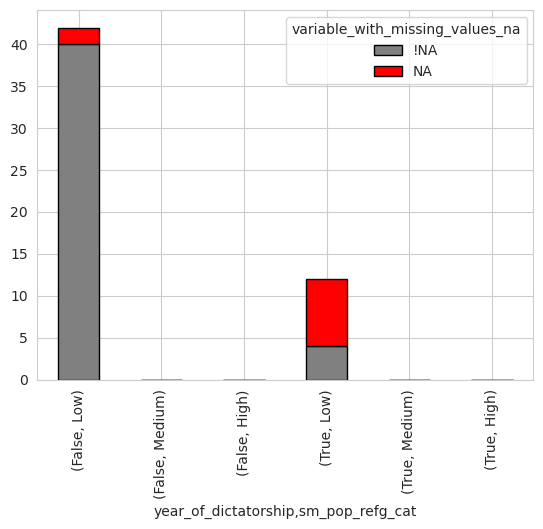

In [14]:
def plot_missing_variables_grouped_by_categories(data, categorical_variable_1, categorical_variable_2, variable_with_missing_values):
    data["variable_with_missing_values_na"] = data[variable_with_missing_values].isna().replace([True, False], ["NA", "!NA"])
    
    size_series = (
        data[[categorical_variable_1, categorical_variable_2, "variable_with_missing_values_na"]]
            .groupby([categorical_variable_1, categorical_variable_2, "variable_with_missing_values_na"], dropna=False, as_index=True)
            .size()
    )

    group_sizes_df = size_series.reset_index(name="size")

    stacked_data = group_sizes_df.pivot_table(
        index=[categorical_variable_1, categorical_variable_2],
        columns="variable_with_missing_values_na",
        values="size",
        fill_value=0  # Fill missing values with 0
    )

    stacked_data.plot(
        kind="bar",
        stacked=True,
        color={"!NA": "grey", "NA": "red"},
        edgecolor="black",
    )
    
plot_missing_variables_grouped_by_categories(arg_di_df.copy(), "year_of_dictatorship", "sm_pop_refg_cat", "sm_pop_refg_or")

### Getting statistics

#### Value counts of most frequent age range for each year

In [15]:
def get_greatest_year_range(row):
    if(row["sp_pop_0014_to_zs"] > row["sp_pop_1564_to_zs"] and row["sp_pop_0014_to_zs"] > row["sp_pop_65_up_to_zs"]): return "0 to 14 years"
    elif(row["sp_pop_1564_to_zs"] > row["sp_pop_65_up_to_zs"] and row["sp_pop_1564_to_zs"] > row["sp_pop_0014_to_zs"]): return "15 to 64 years"
    elif(row["sp_pop_65_up_to_zs"] > row["sp_pop_0014_to_zs"] and row["sp_pop_65_up_to_zs"] > row["sp_pop_1564_to_zs"]): return "65 and above"

arg_di_df["greatest_year_range"] = arg_di_df.apply(lambda x: get_greatest_year_range(x), axis=1)
arg_di_df[["greatest_year_range", ]].value_counts()

greatest_year_range
15 to 64 years         54
Name: count, dtype: int64

In [16]:
arg_di_df.drop(columns=["greatest_year_range"])

,year,it_mlt_main,ny_gdp_mktp_kd,ny_gdp_mktp_kd_zg,ny_gdp_pcap_kd,ny_gdp_pcap_kd_zg,sp_dyn_le00_in,it_cel_sets,sh_dth_imrt,sh_dth_mort,...,se_sec_enrr,se_ter_enrr,sp_urb_totl_in_zs,year_of_dictatorship,sp_pop_00_up_to_zs,sp_totl_zs,ny_gdp_mktp_kd_zg_cat,sp_dyn_le00_in_cat,sm_pop_refg_pct,sm_pop_refg_cat
0,1970,1287000.0,2.207342e+11,3.045643,9257.895572,1.443200,65.589,0.0,32198.0,NaN,...,44.709621,13.377590,78.880,True,100.0,100.0,Moderate growth,Medium life expectancy,0.001468,Low
1,1971,1287000.0,2.332236e+11,5.658131,9628.037838,3.998125,65.541,NaN,32685.0,NaN,...,45.642109,15.440980,79.321,True,100.0,100.0,High growth,Medium life expectancy,0.001404,Low
2,1972,1287000.0,2.370215e+11,1.628417,9630.010366,0.020487,65.923,NaN,33079.0,NaN,...,47.472710,16.620810,79.743,True,100.0,100.0,Low growth,Medium life expectancy,0.001341,Low
3,1973,1287000.0,2.436859e+11,2.811754,9739.416271,1.136093,66.323,NaN,33442.0,NaN,...,49.939709,19.751631,80.158,True,100.0,100.0,Moderate growth,Medium life expectancy,0.001479,Low
4,1974,1287000.0,2.571710e+11,5.533804,10105.049508,3.754160,66.563,NaN,33629.0,40082.0,...,52.762390,22.883011,80.567,False,100.0,100.0,High growth,Medium life expectancy,0.001847,Low
5,1975,1651000.0,2.570980e+11,-0.028412,9935.938635,-1.673528,67.081,0.0,33434.0,39640.0,...,54.387550,27.077160,80.969,False,100.0,100.0,Negative growth,Medium life expectancy,0.001778,Low
6,1976,1678000.0,2.519091e+11,-2.018252,9581.841403,-3.563803,67.228,0.0,32686.0,38536.0,...,55.880482,27.011740,81.366,True,100.0,100.0,Negative growth,Medium life expectancy,0.001560,Low
7,1977,1692000.0,2.693768e+11,6.934148,10083.815183,5.238803,67.861,0.0,31346.0,36750.0,...,55.626678,23.964741,81.755,True,100.0,100.0,High growth,Medium life expectancy,0.001310,Low
8,1978,1728000.0,2.572384e+11,-4.506125,9476.063436,-6.027002,68.197,0.0,29499.0,34382.0,...,55.343731,21.250999,82.139,True,100.0,100.0,Negative growth,Medium life expectancy,0.000972,Low
9,1979,1797000.0,2.835352e+11,10.222763,10278.924624,8.472518,68.491,0.0,27357.0,31734.0,...,54.966290,22.120470,82.516,True,100.0,100.0,High growth,Medium life expectancy,0.000981,Low


##### Ordinary last squares

In [17]:
(
    smf.ols(
        formula="ny_gdp_mktp_kd ~ ny_gdp_pcap_kd + se_sec_enrr", # Regression formula: dependent variable (the variable being predicted) ~ independent variables
        data = arg_di_df
    )
    .fit() # Computes the regression model based on the given data
    .summary() # Provides a detailed report of the regression results
    .tables[0] # Selects the first table from the summary, which contains high-level model details
)

Dep. Variable:,ny_gdp_mktp_kd,R-squared:,0.993
Model:,OLS,Adj. R-squared:,0.992
Method:,Least Squares,F-statistic:,3013.
Date:,"Wed, 19 Mar 2025",Prob (F-statistic):,1.19e-48
Time:,07:30:27,Log-Likelihood:,-1178.6
No. Observations:,48,AIC:,2363.
Df Residuals:,45,BIC:,2369.
Df Model:,2,,
Covariance Type:,nonrobust,,


#### TTest

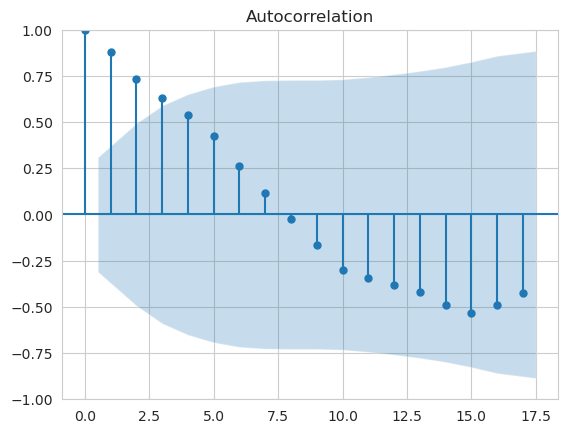

Normality of sample 0? True
Normality of sample 1? True
Equality of variances? False


TtestResult(statistic=-0.4810739437407484, pvalue=0.6329607886872667, df=42.0)

In [18]:
def get_groups_of_missing_values(data, grouping_variable, grouped_variable):

    indexes_of_grouping_variable = arg_di_df.value_counts(grouping_variable, dropna=False).index
    
    grouped_variable = columns_with_missing_values[0]
    grouped_variable_description = get_indicator_name(grouped_variable, True)

    groupby_series = (
        data
            .rename(columns={grouped_variable: grouped_variable_description})
            .loc[:,[grouping_variable, grouped_variable_description]]
            .dropna()
            .groupby(grouping_variable)
    )

    group_1 = pd.DataFrame() if groupby_series.indices.get(indexes_of_grouping_variable[1]) is None else groupby_series.get_group(indexes_of_grouping_variable[1]).loc[:,grouped_variable_description]
    group_2 = pd.DataFrame() if groupby_series.indices.get(indexes_of_grouping_variable[0]) is None else groupby_series.get_group(indexes_of_grouping_variable[0]).loc[:,grouped_variable_description]

    return group_1, group_2

group_1, group_2 = get_groups_of_missing_values(arg_di_df, "year_of_dictatorship", columns_with_missing_values[1])

ttest_ind_and_conditions(group_1,group_2)

What does this plot tell us about the data?

* There is significant autocorrelation at lower lags (strong dependency on past values).
* The autocorrelation decreases over time, eventually turning negative.
* This pattern suggests the data is not purely random and could be modeled using time series techniques, such as an ARMA or ARIMA model (AutoRegressive Moving Average and AutoRegressive Integrated Moving Average respectively)

#### Getting all categorical variables and their values

In [19]:
# We can check dtypes of all columns with arg_di_df.dtypes
categorical_columns = arg_di_df.select_dtypes(include=["object","category"]).columns
categorical_columns

Index(['ny_gdp_mktp_kd_zg_cat', 'sp_dyn_le00_in_cat', 'sm_pop_refg_cat',
       'greatest_year_range'],
      dtype='object')

In [20]:
arg_di_df[categorical_columns[0]].unique().tolist()

['Moderate growth', 'High growth', 'Low growth', 'Negative growth']

#### Ordinal coding
This method implies to transform every category into an integer

##### Applying to a column

In [21]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X= [[item] for item in arg_di_df[categorical_columns[0]].unique().tolist()]

X

[['Moderate growth'], ['High growth'], ['Low growth'], ['Negative growth']]

In [22]:
# Fit to data, then transform it.
encoder.fit_transform(X)

array([[2.],
       [0.],
       [1.],
       [3.]])

In [23]:
encoder.categories_

[array(['High growth', 'Low growth', 'Moderate growth', 'Negative growth'],
       dtype=object)]

In [24]:
encoder.inverse_transform([[0],[1],[2],[3]])

array([['High growth'],
       ['Low growth'],
       ['Moderate growth'],
       ['Negative growth']], dtype=object)

##### Applying to a group of columns


Column transformer: Applies transformers to columns of an array or pandas DataFrame.

make_column_transformer(): Construct a ColumnTransformer from the given transformers. This is a shorthand for the ColumnTransformer constructor; it does not require, and does not permit, naming the transformers. Instead, they will be given names automatically based on their types.


In [25]:
categorical_transformer = sklearn.compose.make_column_transformer(
    # Tuples of the form (transformer, columns) specifying the transformer objects to be applied to subsets of the data
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
    # By specifying remainder='passthrough', all remaining columns that were not specified in transformers,
    # but present in the data passed to fit will be automatically passed through. This subset of columns is
    # concatenated with the output of the transformers. For dataframes, extra columns not seen during fit
    # will be excluded from the output of transform. 
)

In [26]:
arg_di_df_transformed = (
    pd.DataFrame(
        categorical_transformer.fit_transform(arg_di_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=arg_di_df.index
    )
    .rename(
        columns=remove_prefix
    )
)

In [27]:
arg_di_df_transformed[categorical_columns]

,ny_gdp_mktp_kd_zg_cat,sp_dyn_le00_in_cat,sm_pop_refg_cat,greatest_year_range
0,2.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0
3,2.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
5,3.0,1.0,0.0,0.0
6,3.0,1.0,0.0,0.0
7,0.0,1.0,0.0,0.0
8,3.0,1.0,0.0,0.0
9,0.0,1.0,0.0,0.0


#### One hot encoding vs GetDummies
Create a matrix with a column for every categorical variable. Is more useful when there are many possible values.

Getdummies doesn't create a column for either variables that not has a certain value or missing values.

In [28]:
arg_di_df_transformed_2 = arg_di_df.copy(deep=True)

In [29]:
(
    arg_di_df_transformed_2
        .select(columns=categorical_columns[0])
        .pipe(pd.get_dummies)
)

# Another way to write that code: pd.get_dummies(data=arg_di_df_transformed_2.select(columns=categorical_columns[0]))

,ny_gdp_mktp_kd_zg_cat_Negative growth,ny_gdp_mktp_kd_zg_cat_Low growth,ny_gdp_mktp_kd_zg_cat_Moderate growth,ny_gdp_mktp_kd_zg_cat_High growth
0,False,False,True,False
1,False,False,False,True
2,False,True,False,False
3,False,False,True,False
4,False,False,False,True
5,True,False,False,False
6,True,False,False,False
7,False,False,False,True
8,True,False,False,False
9,False,False,False,True


In [30]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),[categorical_columns[0]]),
    (sklearn.preprocessing.OneHotEncoder(),[categorical_columns[0]]),
    remainder="passthrough"
)

In [31]:
arg_di_df_transformed_2 = (
    pd.DataFrame(
        transformer.fit_transform(arg_di_df),
        columns=transformer.get_feature_names_out(),
        index=arg_di_df.index
    )
)

print(categorical_columns[0])
arg_di_df_transformed_2[arg_di_df_transformed_2.columns[arg_di_df_transformed_2.columns.str.contains(categorical_columns[0])]]

ny_gdp_mktp_kd_zg_cat


,ordinalencoder__ny_gdp_mktp_kd_zg_cat,onehotencoder__ny_gdp_mktp_kd_zg_cat_High growth,onehotencoder__ny_gdp_mktp_kd_zg_cat_Low growth,onehotencoder__ny_gdp_mktp_kd_zg_cat_Moderate growth,onehotencoder__ny_gdp_mktp_kd_zg_cat_Negative growth
0,2.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0
3,2.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,1.0
6,3.0,0.0,0.0,0.0,1.0
7,0.0,1.0,0.0,0.0,0.0
8,3.0,0.0,0.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0


In [32]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['High growth', 'Low growth', 'Moderate growth', 'Negative growth'],
       dtype=object)]

In [33]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 1, 0, 0]]
    )
)

array([['Low growth']], dtype=object)

#### Examples of imputation

Using the mean, median and mode

In [34]:
arg_di_df_single_imputation = arg_di_df.copy()
arg_di_df_single_imputation[columns_with_missing_values[0] + "_mean"] = arg_di_df_single_imputation[columns_with_missing_values[0]].fillna(arg_di_df_single_imputation[columns_with_missing_values[0]].mean())
arg_di_df_single_imputation[columns_with_missing_values[0] + "_mode"] = arg_di_df_single_imputation[columns_with_missing_values[0]].fillna(arg_di_df_single_imputation[columns_with_missing_values[0]].mode().iloc[0]) #Arbitrary choice of taking the first mode
arg_di_df_single_imputation[columns_with_missing_values[0] + "_median"] = arg_di_df_single_imputation[columns_with_missing_values[0]].fillna(arg_di_df_single_imputation[columns_with_missing_values[0]].median())

In [35]:

arg_di_df_single_imputation.head()
imputation_columns = [col for col in arg_di_df_single_imputation.columns if col.startswith(columns_with_missing_values[0])]
print(arg_di_df_single_imputation[imputation_columns])

    sm_pop_refg_or  sm_pop_refg_or_mean  sm_pop_refg_or_mode  \
0              NaN           358.977273                 38.0   
1              NaN           358.977273                 38.0   
2              NaN           358.977273                 38.0   
3              NaN           358.977273                 38.0   
4              NaN           358.977273                 38.0   
5              NaN           358.977273                 38.0   
6              NaN           358.977273                 38.0   
7              NaN           358.977273                 38.0   
8              NaN           358.977273                 38.0   
9              NaN           358.977273                 38.0   
10            38.0            38.000000                 38.0   
11            38.0            38.000000                 38.0   
12          1019.0          1019.000000               1019.0   
13            42.0            42.000000                 42.0   
14            42.0            42.000000 

In [36]:
arg_di_df_shadow_matrix = arg_di_df.missing.bind_shadow_matrix(true_string = True, false_string = False, suffix = "_imp")#[[columns_with_missing_values[0]+"_imp",new_variable_name_0,new_variable_name_0 + "_imp"]]
arg_di_df_shadow_matrix

,year,it_mlt_main,ny_gdp_mktp_kd,ny_gdp_mktp_kd_zg,ny_gdp_pcap_kd,ny_gdp_pcap_kd_zg,sp_dyn_le00_in,it_cel_sets,sh_dth_imrt,sh_dth_mort,...,se_ter_enrr_imp,sp_urb_totl_in_zs_imp,year_of_dictatorship_imp,sp_pop_00_up_to_zs_imp,sp_totl_zs_imp,ny_gdp_mktp_kd_zg_cat_imp,sp_dyn_le00_in_cat_imp,sm_pop_refg_pct_imp,sm_pop_refg_cat_imp,greatest_year_range_imp
0,1970,1287000.0,2.207342e+11,3.045643,9257.895572,1.443200,65.589,0.0,32198.0,NaN,...,False,False,False,False,False,False,False,False,False,False
1,1971,1287000.0,2.332236e+11,5.658131,9628.037838,3.998125,65.541,NaN,32685.0,NaN,...,False,False,False,False,False,False,False,False,False,False
2,1972,1287000.0,2.370215e+11,1.628417,9630.010366,0.020487,65.923,NaN,33079.0,NaN,...,False,False,False,False,False,False,False,False,False,False
3,1973,1287000.0,2.436859e+11,2.811754,9739.416271,1.136093,66.323,NaN,33442.0,NaN,...,False,False,False,False,False,False,False,False,False,False
4,1974,1287000.0,2.571710e+11,5.533804,10105.049508,3.754160,66.563,NaN,33629.0,40082.0,...,False,False,False,False,False,False,False,False,False,False
5,1975,1651000.0,2.570980e+11,-0.028412,9935.938635,-1.673528,67.081,0.0,33434.0,39640.0,...,False,False,False,False,False,False,False,False,False,False
6,1976,1678000.0,2.519091e+11,-2.018252,9581.841403,-3.563803,67.228,0.0,32686.0,38536.0,...,False,False,False,False,False,False,False,False,False,False
7,1977,1692000.0,2.693768e+11,6.934148,10083.815183,5.238803,67.861,0.0,31346.0,36750.0,...,False,False,False,False,False,False,False,False,False,False
8,1978,1728000.0,2.572384e+11,-4.506125,9476.063436,-6.027002,68.197,0.0,29499.0,34382.0,...,False,False,False,False,False,False,False,False,False,False
9,1979,1797000.0,2.835352e+11,10.222763,10278.924624,8.472518,68.491,0.0,27357.0,31734.0,...,False,False,False,False,False,False,False,False,False,False


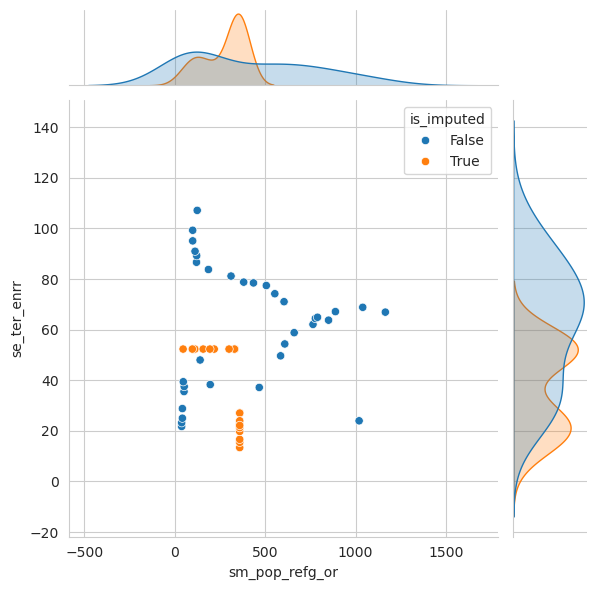

In [37]:
arg_di_df_shadow_matrix = arg_di_df.missing.bind_shadow_matrix(True, False, suffix = "_imp")

arg_di_df_shadow_matrix = (
    arg_di_df_shadow_matrix.assign(
            **{
                columns_with_missing_values[0]: lambda df: df[columns_with_missing_values[0]].fillna(df[columns_with_missing_values[0]].mean()),
                columns_with_missing_values[1]: lambda df: df[columns_with_missing_values[1]].fillna(df[columns_with_missing_values[1]].mean())
            }
        )
)

arg_di_df_shadow_matrix.missing.scatter_imputation_plot(x=columns_with_missing_values[0], y=columns_with_missing_values[1],show_marginal=True)

Using ffill() and bfill()

In [54]:
arg_di_df_single_imputation[columns_with_missing_values[4] + "_ffill"] = arg_di_df_single_imputation[columns_with_missing_values[4]].ffill()
arg_di_df_single_imputation[columns_with_missing_values[4] + "_bfill"] = arg_di_df_single_imputation[columns_with_missing_values[4]].bfill()
arg_di_df_single_imputation[[columns_with_missing_values[4], columns_with_missing_values[4] + "_ffill", columns_with_missing_values[4] + "_bfill"]]

,se_sec_enrr,se_sec_enrr_ffill,se_sec_enrr_bfill
0,44.709621,44.709621,44.709621
1,45.642109,45.642109,45.642109
2,47.472710,47.472710,47.472710
3,49.939709,49.939709,49.939709
4,52.762390,52.762390,52.762390
5,54.387550,54.387550,54.387550
6,55.880482,55.880482,55.880482
7,55.626678,55.626678,55.626678
8,55.343731,55.343731,55.343731
9,54.966290,54.966290,54.966290


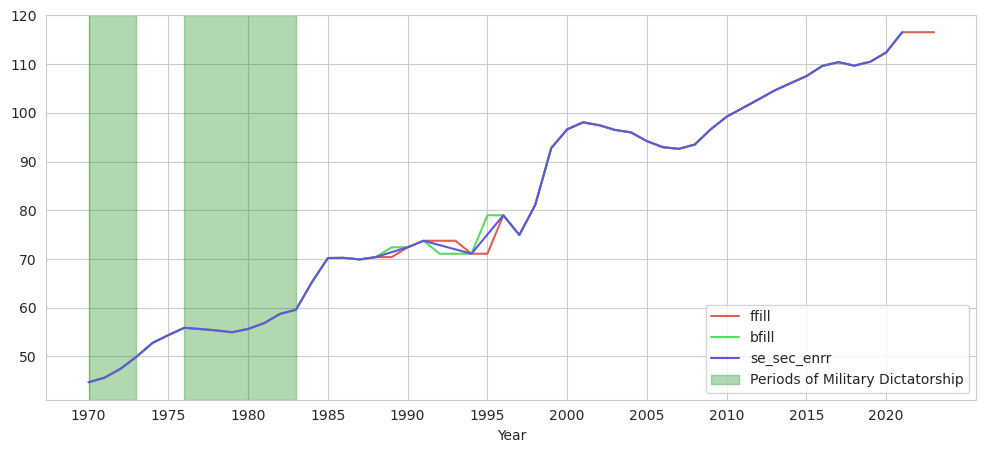

In [80]:
time_series(data=arg_di_df_single_imputation, x="year", y=[columns_with_missing_values[4] + "_ffill", columns_with_missing_values[4] + "_bfill", columns_with_missing_values[4]], plot_labels=["ffill", "bfill", columns_with_missing_values[4]])

Source: https://deepnote.com/workspace/platzi-escuela-datos-83832097-f136-43ff-b38d-abaa022e8ec7/project/datos-faltantes-imputacion-bdf84ff9-f66c-44c7-a67c-ca1115a2b683/notebook/imputation-missing-values-60b90530690647e596864b472f71dfde